In [2]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from counterfactuals.cf_methods import PPCEF
from counterfactuals.datasets.file_dataset import FileDataset
from counterfactuals.losses import BinaryDiscLoss
from counterfactuals.metrics.metrics import evaluate_cf
from counterfactuals.models import MaskedAutoregressiveFlow, MLPClassifier

In [4]:
# Prepare the data

dataset = FileDataset(config_path="../config/datasets/moons.yaml")
# dataset = AdultDataset()

# Get the split data that's already available
X_train = dataset.X_train
X_test = dataset.X_test
y_train = dataset.y_train
y_test = dataset.y_test

train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32),
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
)

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

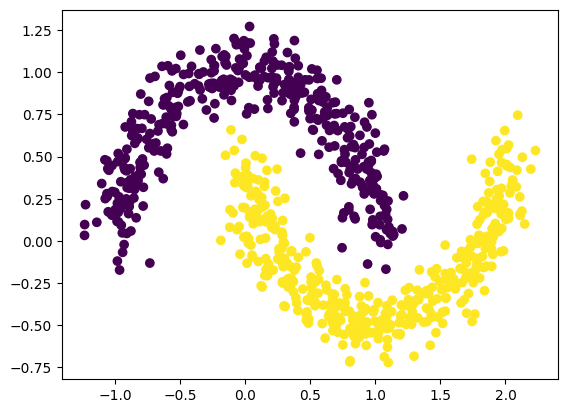

In [5]:
for X, y in train_dataloader:
    plt.scatter(X[:, 0], X[:, 1], c=y)

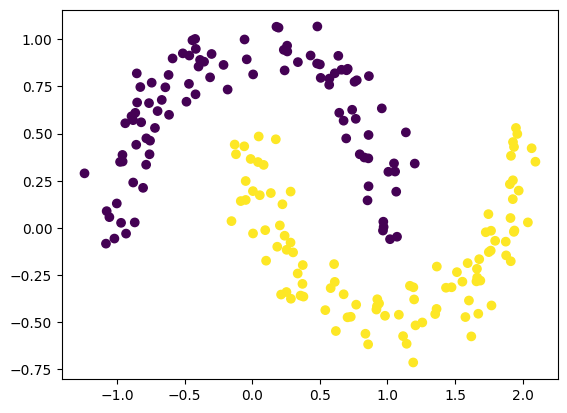

In [6]:
for X, y in test_dataloader:
    plt.scatter(X[:, 0], X[:, 1], c=y)

In [7]:
# Train a discriminative model
num_inputs = X_train.shape[1]
num_targets = 1

discrimaiative_model = MLPClassifier(
    num_inputs=num_inputs,
    num_targets=num_targets,
    hidden_layer_sizes=[64, 32],  # Added required parameter
)
discrimaiative_model.fit(
    train_dataloader, test_dataloader, epochs=10000, patience=600, lr=0.01
)

Epoch 2194, Train: 0.0707, test: 0.0685, patience: 600:  22%|██▏       | 2195/10000 [00:09<00:32, 240.88it/s]


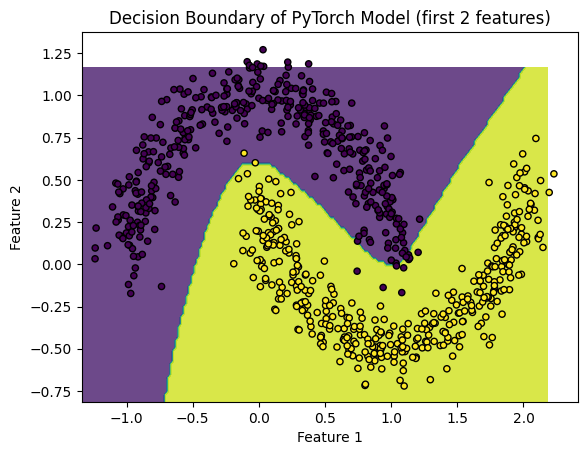

In [8]:
# Create a mesh grid for plotting decision boundaries (using first two features)
h = 0.02
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Build full-dimensional grid points: fill other features with the training mean
discrimaiative_model.eval()
with torch.no_grad():
    n_points = xx.ravel().shape[0]
    # base vector: mean of training features (shape: num_features,)
    base = np.tile(X_train.mean(axis=0), (n_points, 1))
    # replace first two columns with grid coordinates
    base[:, 0] = xx.ravel()
    base[:, 1] = yy.ravel()
    # convert to torch tensor for prediction
    grid_points_full = torch.tensor(base, dtype=torch.float32)
    Z = discrimaiative_model.predict(grid_points_full)
    Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8)
# scatter a sample of training points (first two features)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor="k", s=20)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision Boundary of PyTorch Model (first 2 features)")
plt.show()

In [9]:
# Train a generative model (Masked Autoregressive Flow)

gen_model = MaskedAutoregressiveFlow(
    num_inputs=num_inputs,
    num_targets=num_targets,
    features=dataset.X.shape[1],
    hidden_features=8,
    context_features=1,
)

# Create dataloader with noise for generative model training
train_dataset_gen = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32),
)

gen_train_dataloader = DataLoader(train_dataset_gen, batch_size=1024, shuffle=True)
gen_model.fit(gen_train_dataloader, test_dataloader, num_epochs=1000, patience=100)

Epoch 964, Train: 0.3198, test: 0.4377, patience: 100:  96%|█████████▋| 964/1000 [00:06<00:00, 147.34it/s]


In [10]:
# Create the counterfactual explainer
cf = PPCEF(
    gen_model=gen_model,
    disc_model=discrimaiative_model,
    disc_model_criterion=BinaryDiscLoss(),
)

# Create dataloader for counterfactual generation
cf_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
)

# Create dataloader for counterfactual generation
cf_dataloader = DataLoader(cf_dataset, batch_size=1024, shuffle=False)

# Compute predictions for the dataloader correctly (predict expects arrays/tensors, not a DataLoader)
all_preds = []
with torch.no_grad():
    for xb, yb in cf_dataloader:
        preds = gen_model.predict(xb)
        all_preds.append(preds.ravel())
    all_preds = np.concatenate(all_preds)
# compute threshold as the 25th percentile of predicted log-probs (or predictions)
log_prob_threshold = np.quantile(all_preds, 0.25)
deltas, X_orig, y_orig, y_target, logs = cf.explain_dataloader(
    cf_dataloader, alpha=100, log_prob_threshold=log_prob_threshold, epochs=4000
)

Discriminator loss: 0.0112, Prob loss: 0.0191: 100%|██████████| 4000/4000 [00:08<00:00, 497.88it/s]


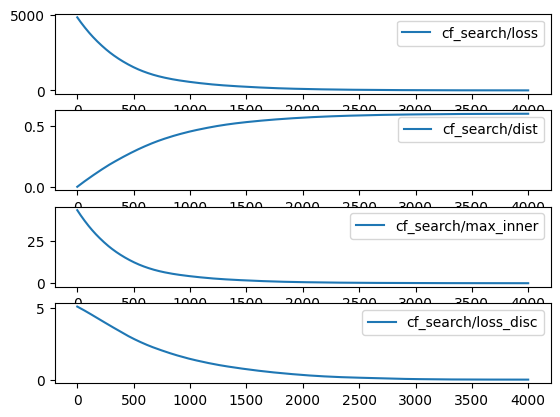

In [11]:
for i, (log_name, log_vals) in enumerate(logs.items()):
    plt.subplot(len(logs), 1, i + 1)
    plt.plot(log_vals, label=log_name)
    plt.legend()

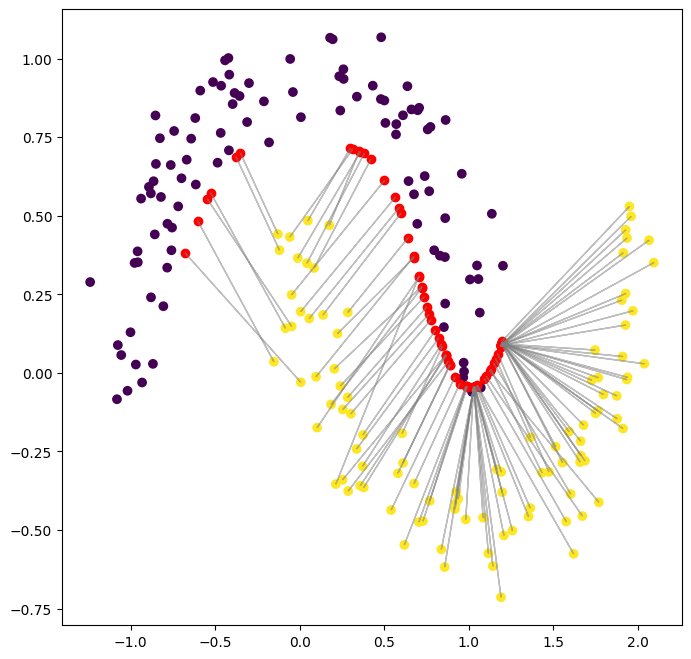

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
X_cf = X_orig + deltas
i = y_orig.reshape(-1) == 1
ax.scatter(X_orig[:, 0], X_orig[:, 1], c=y_orig)
ax.scatter(X_orig[i, 0] + deltas[i, 0], X_orig[i, 1] + deltas[i, 1], c="r")
for before, after in zip(X_orig[i], X_cf[i]):
    ax.arrow(
        before[0],
        before[1],
        after[0] - before[0],
        after[1] - before[1],
        head_width=0.0,
        head_length=0.0,
        fc="gray",
        ec="gray",
        alpha=0.5,
        width=0.0001,
    )

In [13]:
# Evaluate the counterfactuals
evaluate_cf(
    disc_model=discrimaiative_model,
    gen_model=gen_model,
    X_cf=X_cf,
    model_returned=np.ones(X_cf.shape[0]),
    continuous_features=dataset.config.continuous_features,
    categorical_features=dataset.config.categorical_features,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_orig,
    y_test=y_orig,
    median_log_prob=log_prob_threshold,
    y_target=y_target,
)

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'